In [ ]:
# %pip install "unstructured[md]" nltk langchain-text-splitters

## **Single Document**

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langchain.document_loaders import TextLoader

# Load
markdown_path = "./Processed_Files_Introduction_to_End/Copia di iec61158-1{ed1.0}b.md"
loader = TextLoader(markdown_path, autodetect_encoding=True)
doc = loader.load()
doc[0]

In [ ]:
headers_to_split_on = [
    ("#", "Header 1"),
    ("###", "Header 3"),
    ("####", "Header 4"),
]

# MD splits
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on, strip_headers=False
)
md_header_splits = markdown_splitter.split_text(doc[0].page_content)
md_header_splits

In [ ]:
# Char-level splits
chunk_size = 1000
chunk_overlap = 200
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, chunk_overlap=chunk_overlap
)

# Split
splits = text_splitter.split_documents(md_header_splits)
splits

## **All Documents**

In [47]:
import glob
import os
from langchain_core.documents import Document

In [48]:
# 1. Path/pattern for markdown files
folder_path = "./Processed_Files_Introduction_to_End/*.md"

# 2. Parameters for the Header Splitter
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
    ("####", "Header 4"),
]
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on, 
    strip_headers=False
)

# 3. Parameters for the character-level splitter
chunk_size = 1000
chunk_overlap = 200
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, 
    chunk_overlap=chunk_overlap
)

# Final list for all splits from all files
all_splits = []

for file_path in glob.glob(folder_path):
    # a) Load the file as raw text (preserving Markdown)
    loader = TextLoader(file_path, autodetect_encoding=True)
    docs = loader.load()  # usually returns a list [Document]
    
    # b) For each Document, perform two splits
    for doc in docs:
        md_header_splits = markdown_splitter.split_text(doc.page_content)
        splits = text_splitter.split_documents(md_header_splits)
        
        # c) Use the base file name as "name_file" (without the path and without extension)
        filename = os.path.splitext(os.path.basename(file_path))[0]

        for splitted_doc in splits:
            splitted_doc.metadata["name_file"] = filename
            # Optionally, remove the original "source" if not needed:
            # splitted_doc.metadata.pop("source", None)

        all_splits.extend(splits)

In [ ]:
min_size = 1000  # Minimum size for the merged chunks
merged_documents = []  # List to store merged documents
buffer_content = ""
buffer_metadata = {}

for doc in all_splits:
    text = doc.page_content.strip()  # remove extra spaces if necessary
    # If there is no content accumulated in the buffer and the chunk is small,
    # initialize the buffer with this chunk.
    if not buffer_content and len(text) < min_size:
        buffer_content = text
        buffer_metadata = doc.metadata
    # If there is already content in the buffer, concatenate it with the current chunk.
    elif buffer_content:
        buffer_content += "\n" + text  # add a line break to separate the texts
        # When the buffer reaches or exceeds the minimum size, create a Document
        if len(buffer_content) >= min_size:
            merged_documents.append(
                Document(page_content=buffer_content, metadata=buffer_metadata)
            )
            buffer_content = ""
            buffer_metadata = {}
    # If the current chunk is already large enough and there is nothing in the buffer, add it directly.
    elif len(text) >= min_size:
        merged_documents.append(Document(page_content=text, metadata=doc.metadata))

# If there is remaining content in the buffer, add it as well.
if buffer_content:
    merged_documents.append(Document(page_content=buffer_content, metadata=buffer_metadata))

# Example of printing the results:
for i, document in enumerate(merged_documents):
    print(f"Document {i+1}:")
    print("Metadata:", document.metadata)
    print("Content (first 200 characters):", document.page_content[:200])
    print("-" * 50)

In [ ]:
print(f"Generated {len(all_splits)} chunks in total.")

In [ ]:
print(f"Generated {len(merged_documents)} chunks in total.")

In [ ]:
merged_documents

## **RAG**

In [14]:
from langchain_ollama import OllamaEmbeddings
from langchain.vectorstores import FAISS
from langchain_ollama import ChatOllama
from langchain.schema import Document
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
from pprint import pprint
from langchain_core.prompts import ChatPromptTemplate
from typing_extensions import TypedDict
from typing import List

In [15]:
# Example embeddings (you can use OpenAIEmbeddings or another)
embeddings = OllamaEmbeddings(model="nomic-embed-text:latest")

# Create an in-memory local vector store (FAISS)
# vector_store = FAISS.from_documents(merged_documents, embedding=embeddings)

In [16]:
# vector_store.save_local("faiss_index")

In [17]:
vector_store = FAISS.load_local("eng_faiss_index", embeddings, allow_dangerous_deserialization=True)

In [18]:
# Example of an LLM
llm = ChatOllama(temperature=0, model="gemma3:12b")

In [19]:
template = """You are an AI language model assistant that understands PROFIBUS-related documents and specifications in the context of industrial automation.

IMPORTANT: FOCUS **ONLY ON PROFIBUS**.  
DO NOT INCLUDE **ANYTHING** ABOUT PROFINET.  
DO NOT INCLUDE **ANYTHING** ABOUT CANOPEN.  
THIS IS **ONLY** ABOUT PROFIBUS.  
REPEAT: **PROFIBUS ONLY**.  
IGNORE ALL OTHER PROTOCOLS.

### Instructions:
- Answer in a clear, informative, and technically accurate manner.
- Provide a **complete and relevant explanation**, but avoid excessive detail.
- Start with a **direct answer**, then expand with useful clarification, examples, or context if appropriate.
- Avoid unnecessary filler or repetition.
- Answer **in the same language as the question**.
- You can say "I don't know" if you don't know the answer.

### Now answer the following:

Question: {question}

Context: {context}

Answer (in the language of the question):  
"""

prompt = ChatPromptTemplate.from_template(template)

In [20]:
class State(TypedDict):
    question: str           # User's question
    context: List[Document] # Documents returned by the retrieve function
    answer: str             # Final answer from the LLM

def retrieve(state: State):
    """
    Retrieval step: performs a similarity search in the vector_store
    and returns the documents that will serve as context for the answer.
    
    Args:
        state (State): The current state containing the user's question.
    
    Returns:
        dict: A dictionary with the key "context" that will be added to the state.
    """
    retrieved_docs = vector_store.similarity_search(state["question"], k=5)
    # Returns a dictionary with the key "context"
    return {"context": retrieved_docs}

def generate(state: State):
    """
    Generation step: formats the 'context' and the 'question' into a prompt,
    calls the LLM, and obtains the final answer.
    
    Args:
        state (State): The current state containing the user's question and the retrieved context.
    
    Returns:
        dict: A dictionary with the key "answer" containing the final answer from the LLM.
    
    Raises:
        ValueError: If the response format from the LLM is unexpected.
    """
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    
    response = llm.invoke(messages)  # or llm(messages), depending on your setup

    # If the response is of type AIMessage and has the attribute 'content', use it:
    if hasattr(response, "content"):
        return {"answer": response.content}
    elif isinstance(response, str):
        return {"answer": response}
    else:
        raise ValueError("Unexpected response format.")

In [21]:
# Build the application graph:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")

# Compile into a callable "graph" object
graph = graph_builder.compile()

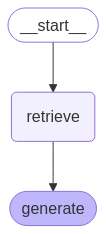

In [22]:
display(Image(graph.get_graph().draw_mermaid_png()))

## **Queries**

In [ ]:
import re
from pprint import pprint

def clean_answer(answer: str) -> str:
    """
    Cleans the generated answer by removing unnecessary information and formatting.
    
    Args:
        answer (str): The raw answer generated by the LLM.
        
    Returns:
        str: The cleaned answer, formatted for better readability.
    """

    # Remove logs such as INFO:langchain...
    cleaned = re.sub(r'INFO:.*?(\n|$)', '', answer)

    # Extract the value of the 'answer' key if it's a dictionary string
    match = re.search(r"'answer':\s*([\"'])(.*?)\1", cleaned, re.DOTALL)
    if match:
        cleaned = match.group(2)

    # Remove markdown bold formatting **text**
    cleaned = re.sub(r"\*\*(.*?)\*\*", r"\1", cleaned)

    # Remove duplicate spaces and normalize line breaks
    cleaned = re.sub(r'\n{3,}', '\n\n', cleaned)
    cleaned = re.sub(r'[ \t]+$', '', cleaned, flags=re.MULTILINE)

    return cleaned.strip()

def clean_context(context):
    """
    Simplifies the context by extracting relevant metadata and limiting content length.
    
    Args:
        context (List[Document]): The list of documents retrieved as context.
        
    Returns:
        List[dict]: A simplified list of dictionaries containing the document ID and a snippet of the content.
    """
    
    return [
        {
            "id": doc.metadata.get("name_file", doc.metadata.get("source", "unknown")),
            "content": doc.page_content[:300] + "..." if len(doc.page_content) > 300 else doc.page_content
        }
        for doc in context
    ]

def process_question(question: str):
    """
    Process a user's question by retrieving context and generating an answer using the graph.

    Args:
        question (str): The user's question.

    Prints:
        The retrieved context and the generated answer.
    """
    for step_result in graph.stream({"question": question}, stream_mode="updates"):
        if "retrieve" in step_result:
            context = step_result.get("retrieve", {}).get("context", [])
            simplified_context = clean_context(context)
            print("\n📚 Retrieved Context:\n")
            pprint(simplified_context)

        if "generate" in step_result:
            raw_answer = step_result.get("generate", {}).get("answer", "")
            formatted_answer = clean_answer(raw_answer)
            print("\n🧠 Generated Answer:\n")
            print(formatted_answer)

### 1 - List the main causes of reflections in Profibus cables.

In [25]:
question_1 = "List the main causes of reflections in Profibus cables"
process_question(question_1)


📚 Retrieved Context:

[{'content': '# **PROFIBUS cable too long**  \n'
             'Cable that is too long generally functions like a condenser. It '
             'changes the signal form. The result is that for a square wave '
             'signal the rising edge is rounded (e-function). This effect is '
             'more pronounced the longer the PROFIBUS cable.  \n'
             'If the signal is changed too d...',
  'id': 'Copia di PROFIBUS_Commissioning_8032_V123_Sep22 (1)'},
 {'content': 'The supply voltage can also be checked with a multimeter. The '
             'measurement is performed between pin 5 (+5 V) and pin 6 (Earth) '
             'of the 9-pin sub-D connector.  \n'
             '• Step 3: Generate a live list  \n'
             'Check whether all PROFIBUS stations can be reached. Many '
             'handheld devices support this feature. Some programm...',
  'id': 'Copia di PROFIBUS_Commissioning_8032_V123_Sep22 (1)'},
 {'content': '#### **Standard cables**  \n'
 

### 2 - What are the different interference coupling mechanisms in Profibus cables? What measures can be taken to reduce each type of interference?

In [26]:
question_2 = "What are the different interference coupling mechanisms in Profibus cables? What measures can be taken to reduce each type of interference?"
process_question(question_2)


📚 Retrieved Context:

[{'content': '# **PROFIBUS cable too long**  \n'
             'Cable that is too long generally functions like a condenser. It '
             'changes the signal form. The result is that for a square wave '
             'signal the rising edge is rounded (e-function). This effect is '
             'more pronounced the longer the PROFIBUS cable.  \n'
             'If the signal is changed too d...',
  'id': 'Copia di PROFIBUS_Commissioning_8032_V123_Sep22 (1)'},
 {'content': '### <span id="page-24-1"></span>**2.1.4 Radiated coupling**  \n'
             'In industrial cables of usually up to 100 m of length, radiated '
             'coupling between high-energy disturbers and signal current '
             'circuits only occurs at high frequencies (approx. 30 MHz and '
             'higher). This type of coupling is caused by the electr...',
  'id': 'Copia di Earthing-Shielding_8102_V31_Sep22'},
 {'content': 'The hybrid plug systems also include a variant for transm

### 3 - In which situations should spur lines not be used in Profibus DP network topology?

In [27]:
question_3 = "In which situations should spur lines not be used in Profibus DP network topology?"
process_question(question_3)


📚 Retrieved Context:

[{'content': '# **PROFIBUS DP topology using copper cables**  \n'
             'When using copper cables without additional active components, '
             'the PROFIBUS DP within a segment has a pure linear topology.  \n'
             '![](_page_38_Figure_6.jpeg)  \n'
             '<span id="page-38-0"></span>**Figure 2-5: Line topology of a '
             'PROFIBUS DP with copper cables**  ...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'content': '# **2.3.1.4 PROFIBUS types for hazardous areas**  \n'
             'There are two special PROFIBUS types that are explicitly '
             'specified for use in hazardous areas. These types allow for '
             'integrating intrinsically safe segments into a line.\n'
             '# **2.3.1.5 PROFIBUS DP-IS**  \n'
             'A special variant called PROFIBUS DP-IS was deve...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'content': '# **PROFIBUS DP topolog

### 4 - Determine the minimum separation distance between a Profibus cable and the following cables:
a. AS-Interface type Profibus cable

b. 24V power cable for a digital output module

c. Single-phase 240V AC power cable for supplying a DC power supply

d. Grounding equipotential bonding cable between cabinets

e. Three-phase 380V power cable for a Profibus frequency inverter

In [ ]:
question_4 = """Determine the minimum separation distance between a Profibus cable and the following cables:

a. AS-Interface type Profibus cable

b. 24V power cable for a digital output module

c. Single-phase 240V AC power cable for supplying a DC power supply

d. Grounding equipotential bonding cable between cabinets

e. Three-phase 380V power cable for a Profibus frequency inverter"""
process_question(question_4)


📚 Retrieved Context:

[{'content': '#### This results in:  \n'
             '*Recommended\\_distance* = 2 *Minimum\\_Distance '
             'Minimum\\_Distance* = *S P Recommended\\_distance = 2 S P '
             'Recommended\\_distance =* 2 8 mm 2 = 32 mm\n'
             '#### **Disclaimer:**  \n'
             'The information regarding the minimum cable distances refers to '
             'installations in which PROFINET / PROFIBUS c...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'content': '|                                 | 13 to 15           | '
             '1,0                              |  |\n'
             '| 20<br>A, 230<br>V, single-phase | 16 to 30           | '
             '2                                |  |\n'
             '|                                 | 31 to 45           | '
             '3                                |  |\n'
             '|              ...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},


### 5 - Two control rooms located at opposite ends of an area must share the same Profibus network. Each room has its own grounding system, and there is a significant potential difference between them. List three methods to install the network in a way that avoids issues caused by separate ground potentials.

In [ ]:
question_5 = "Two control rooms located at opposite ends of an area must share the same Profibus network. Each room has its own grounding system, and there is a significant potential difference between them. List three methods to install the network in a way that avoids issues caused by separate ground potentials."
process_question(question_5)


📚 Retrieved Context:

[{'content': '#### **Use for potential separation**  \n'
             'If the individual plant parts are powered from different mains '
             'supplies, differences may occur in the ground potential which '
             'may corrupt the data transmission. In this case repeaters could '
             'be used to provide a potential separation.\n'
             '# <span id="page-93-0"></spa...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'content': '| P6 | •<br>In order to keep the cables between the power supply '
             'unit and the con<br>sumer as short as possible, it is '
             'recommended to use several smaller<br>power supplies rather than '
             'a single big one.<br>See also chapter 4.6 |\n'
             '# <span id="page-106-0"></span>**6 Summary of the '
             'recommendations for th...',
  'id': 'Copia di Earthing-Shielding_8102_V31_Sep22'},
 {'content': 'Accordingly many PROFIBUS stations wou

### 6 - Discuss the factors that have a significant effect on the overall cycle time of a DP network.

In [ ]:
question_6 = "Discuss the factors that have a significant effect on the overall cycle time of a DP network."
process_question(question_6)


📚 Retrieved Context:

[{'content': '#### <span id="page-56-0"></span>**Figure 2-12: PROFIBUS bus '
             'cycle times**  \n'
             '(PA)  \n'
             'Compared to the bus cycle time of PROFIBUS DP, the bus cycle '
             'time of PROFIBUS-MBP (PA) is quite long. However, this does not '
             'necessarily mean that the total cycle time of a line consisting '
             'of both PROFIBUS DP and PRO...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'content': '# **PROFIBUS DP**  \n'
             'An estimation of the bus cycle time for PROFIBUS DP can be made '
             'using the formula provided in [Table 2-6.](#page-53-0)  \n'
             '<span id="page-53-0"></span>![](_page_53_Figure_3.jpeg)  \n'
             '![](_page_53_Figure_4.jpeg)  \n'
             '[Figure 2-11](#page-54-0) provides a graphical overview of the '
             'formula ...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'co

### 7 - A PA segment is used to wire 24 slave devices in a non-hazardous area. Determine the maximum spur length when:
a. Each spur carries only one slave,

b. Each spur carries four slaves.

What is the maximum length of the main trunk cable in each case?

In [ ]:
question_7 = """A PA segment is used to wire 24 slave devices in a non-hazardous area. Determine the maximum spur length when:
a. Each spur carries only one slave,

b. Each spur carries four slaves.

What is the maximum length of the main trunk cable in each case?"""
process_question(question_7)


📚 Retrieved Context:

[{'content': '| Number of | Maximum spur length<br>(only 1 device per spur) |  '
             '|  |\n'
             '|-----------|-------------------------------------------------|--|--|\n'
             '| 1 –       | 120                                             |  '
             '|  |\n'
             '| 12        | m                                               |  '
             '|  |\n'
             '| 13 –      | 90    ...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'content': '|-------------------------------------------------------------------------------------------|--|--|--|  \n'
             'The maximum distances listed above are valid for an individual '
             'segment, provided that type A PROFIBUS cable is used (see also '
             'chapter [3.1.1.1\\)](#page-70-1). Using repeaters allows you to '
             'couple...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'content': '#### <s

### 8 - Does PA wiring have to use screened twisted pair cable?

In [ ]:
question_8 = "Does PA wiring have to use screened twisted pair cable?"
process_question(question_8)


📚 Retrieved Context:

[{'content': '# **DP/MBP (PA) segment couplers**  \n'
             'A segment coupler consists of a gateway module and power supply '
             'modules for up to four segments.  \n'
             'The DP/MBP (PA) segment couplers are transparent in terms of '
             'communication; the bus addresses of the PROFIBUS-MBP (PA) slaves '
             'are visible on the PROFIBUS DP side. T...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'content': '| Cable                        | Twisted, shielded two<br>wire '
             'cable,<br>cable type A                       | Twisted, shielded '
             'four<br>wire cable,<br>cable type A, acc. to<br>IEC 61158 part '
             '3/1 | Twisted, shielded two<br>wire cable,<br>cable type '
             'A         | Twisted, shielded two<br>wire cable,<br>...',
  'id': 'Copia di PROFIBUS_Systembeschreibung_ENG_web'},
 {'content': 'A two-core shielded cable is used for the transmissio

### 9 - A non-hazardous plant is currently fitted with 4 to 20 mA instrumentation, wired using a mixture of single and multi-core cable. What are the main considerations when considering moving over to a PROFIBUS PA system?

In [ ]:
question_9 = "A non-hazardous plant is currently fitted with 4 to 20 mA instrumentation, wired using a mixture of single and multi-core cable. What are the main considerations when considering moving over to a PROFIBUS PA system?"
process_question(question_9)


📚 Retrieved Context:

[{'content': '### <span id="page-35-0"></span>**3.3 Acceptance Measurements - '
             'PROFIBUS MBP (PA)**  \n'
             'The PROFIBUS MBP (PA) wiring can be checked with a multimeter or '
             'installation tester. Chapter [6.2.3](#page-89-1) describes how '
             'to do this. A checklist for the acceptance measurements for '
             'PROFIBUS MBP (PA) can be f...',
  'id': 'Copia di PROFIBUS_Commissioning_8032_V123_Sep22 (1)'},
 {'content': '#### **Fig. 24: Stepwise introduction of PROFINET in the '
             'intrinsically safe field**\n'
             '#### **PROFIBUS PA remains a key technology**  \n'
             'PROFIBUS PA enables long cable distances and explosion '
             'protection in process automation as well as the native, digital '
             'integration of field instrumentation in control s...',
  'id': 'Copia di PROFIBUS_Systembeschreibung_ENG_web'},
 {'content': '#### **PROFIBUS components**  \n'
     

### 10 - Determine the maximum trunk and spur cable lengths for a non-intrinsically safe MBP segment with 20 slaves each connected via the maximum possible spur length. Estimate the required coupler current rating if each slave device takes a maximum of 14 mA.

In [ ]:
question_10 = "Determine the maximum trunk and spur cable lengths for a non-intrinsically safe MBP segment with 20 slaves each connected via the maximum possible spur length. Estimate the required coupler current rating if each slave device takes a maximum of 14 mA."
process_question(question_10)


📚 Retrieved Context:

[{'content': '#### <span id="page-47-1"></span>**Table 2-4: Maximum spur '
             'lengths with PROFIBUS-MBP (PA)**  \n'
             '| Number of devices<br>incl. DP/PA convert | Maximum length of '
             'a<br>spur in m | Maximum length in m of a<br>spur intrinsically '
             'safe to |\n'
             '|------------------------------------------|-------------------------...',
  'id': 'Copia di PROFIBUS_Design_Guideline_8012_V129_Sep20 (1)'},
 {'content': '![](_page_12_Figure_7.jpeg)  \n'
             '**Fig. 6: The connection of DP and PA segments**  \n'
             '**If MBP transmission technology is used** (in process '
             'automation), basically any topology is permissible. Linear and '
             'tree structures and combinations of both are thus possible. In '
             'practice, the "trunk & spur topology" ...',
  'id': 'Copia di PROFIBUS_Systembeschreibung_ENG_web'},
 {'content': '# **3.2.3.1 Instructions for PROFIB